# Reporting with Spark

This notebook demonstrates basic reporting workflows using Spark as the query engine and Pandas/Seaborn for visualization. It loads the data from the project's SQLite DW via JDBC, performs light data quality checks, computes a few aggregates (top customers, sales by region, region × category), and presents simple visualizations with short interpretations.

Notebook flow:
1. Start Spark and load tables
2. Quick data quality checks
3. Parse dates and filter recent data
4. Aggregations and visualizations (top customers, region, regionxcategory)
   


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [2]:
from pyspark.sql import SparkSession

jdbc_jar = "/Users/kevinhennelly/Repos/smart-store-kevinhennelly/data/lib/sqlite_jdbc-3.51.0.0.jar"

spark = (
    SparkSession.builder
    .appName("SmartSalesDW")
    .config("spark.jars", jdbc_jar)
    .config("spark.driver.extraClassPath", jdbc_jar)
    .config("spark.executor.extraClassPath", jdbc_jar)
    .getOrCreate()
)

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/15 20:13:07 WARN Utils: Your hostname, Kevins-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.40.16.12 instead (on interface en0)
25/11/15 20:13:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/15 20:13:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
jdbc_url = "jdbc:sqlite:/Users/kevinhennelly/Repos/smart-store-kevinhennelly/data/dw/smart_sales.dw"

df_sales = (
    spark.read
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", "sales")
    .option("driver", "org.sqlite.JDBC")
    .load()
)

df_customers = (
    spark.read
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", "customers")
    .option("driver", "org.sqlite.JDBC")
    .load()
)

df_sales.show(5)
df_customers.show(5)

+-------+----------+-----------+----------+--------+-----------+-----------------+--------+------------+
|sale_id|      date|customer_id|product_id|store_id|campaign_id|payment_method_id|quantity|sales_amount|
+-------+----------+-----------+----------+--------+-----------+-----------------+--------+------------+
|      1|2025-05-04|       1034|      2059|     402|        0.0|             Visa|       2|      2048.2|
|      2|2025-05-04|       1066|      2048|     403|        1.0|             Visa|       1|      321.87|
|      3|2025-05-04|       1116|      2041|     403|        3.0|         ApplePay|       2|     3216.84|
|      4|2025-05-04|       1071|      2096|     404|        2.0|             Visa|       5|     1613.23|
|      5|2025-05-04|       1020|      2060|     401|        0.0|             Visa|       2|      408.38|
+-------+----------+-----------+----------+--------+-----------+-----------------+--------+------------+
only showing top 5 rows
+-----------+-------------+----

In [4]:
# Reuse the same jdbc_url you used before
jdbc_url = "jdbc:sqlite:/Users/kevinhennelly/Repos/smart-store-kevinhennelly/data/dw/smart_sales.dw"

df_products = (
    spark.read
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", "products")
    .option("driver", "org.sqlite.JDBC")
    .load()
)

df_products.show(5)
df_products.printSchema()

+----------+--------------------+-----------+----------+-----------+------------+
|product_id|        product_name|   category|unit_price|stock_level|discontinued|
+----------+--------------------+-----------+----------+-----------+------------+
|      2000|      Electronics-Be|Electronics|    969.31|         41|           1|
|      2001|      Electronics-Be|   Clothing|    412.35|         69|           1|
|      2002|       Office-Family|   Clothing|     866.0|        218|           0|
|      2003|Electronics-Training|   Clothing|    385.18|        166|           0|
|      2004|        Office-Where|       Home|    927.25|        136|           0|
+----------+--------------------+-----------+----------+-----------+------------+
only showing top 5 rows
root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- stock_level: integer (nullable = true)
 |-- discontinued: in

In [5]:
df_sales.createOrReplaceTempView("sales")
df_customers.createOrReplaceTempView("customers")
df_products.createOrReplaceTempView("products")

## Data quality checks

Do a few quick checks: show schema, look for obvious parsing issues (bad dates, missing values). Note any data quality issues here so we can handle them before aggregations.

In [6]:
# Print schemas to confirm column names and types
df_sales.printSchema()
df_customers.printSchema()
df_products.printSchema()

# Example: show rows with potentially problematic SaleDate values or missing critical fields
try:
    df_sales.filter(F.col("SaleDate").isNull() | (F.length(F.col("SaleDate")) == 0)).show(5)
except Exception:
    # if column uses different case, fall back to a permissive check
    display(df_sales.limit(5))

{"ts": "2025-11-15 20:13:15.029", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `SaleDate` cannot be resolved. Did you mean one of the following? [`date`, `sale_id`, `quantity`, `sales_amount`, `store_id`]. SQLSTATE: 42703", "context": {"file": "line 8 in cell [6]", "line": "", "fragment": "col", "errorClass": "UNRESOLVED_COLUMN.WITH_SUGGESTION"}, "exception": {"class": "Py4JJavaError", "msg": "An error occurred while calling o43.filter.\n: org.apache.spark.sql.AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `SaleDate` cannot be resolved. Did you mean one of the following? [`date`, `sale_id`, `quantity`, `sales_amount`, `store_id`]. SQLSTATE: 42703;\n'Filter 'or('isNull('SaleDate), '`=`('length('SaleDate), 0))\n+- Relation [sale_id#0,date#1,customer_id#2,product_id#3,store_id#4,campaign_id#5,payment_method_id#6,quantity#

root
 |-- sale_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- campaign_id: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- sales_amount: double (nullable = true)

root
 |-- customer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- region: string (nullable = true)
 |-- join_date: string (nullable = true)
 |-- last_purchase_date: string (nullable = true)
 |-- email_opt_in: integer (nullable = true)

root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- stock_level: integer (nullable = true)
 |-- discontinued: integer (nullable = true)



DataFrame[sale_id: int, date: string, customer_id: string, product_id: string, store_id: string, campaign_id: string, payment_method_id: string, quantity: int, sales_amount: double]

## Normalize and parse dates

Create a parsed order_date column from the sales date field and keep only recent data (2023 onward) for trend-focused reporting.

In [7]:
from pyspark.sql import functions as F

# Parse the date string into a proper date
df_sales_with_date = df_sales.withColumn("order_date", F.to_date("date"))

# Slice: keep only sales from 2023-01-01 onward
df_sales_2023 = df_sales_with_date.filter(F.col("order_date") >= F.lit("2023-01-01"))

df_sales_2023.select("sale_id", "order_date", "customer_id", "sales_amount").show(10)

+-------+----------+-----------+------------+
|sale_id|order_date|customer_id|sales_amount|
+-------+----------+-----------+------------+
|      1|2025-05-04|       1034|      2048.2|
|      2|2025-05-04|       1066|      321.87|
|      3|2025-05-04|       1116|     3216.84|
|      4|2025-05-04|       1071|     1613.23|
|      5|2025-05-04|       1020|      408.38|
|      6|2025-05-04|       1089|     1275.88|
|      7|2025-05-04|       1193|      346.66|
|      8|2025-05-04|       1005|      855.49|
|      9|2025-05-04|       1032|      735.08|
|     10|2025-05-04|       1119|      661.63|
+-------+----------+-----------+------------+
only showing top 10 rows


## Top customers (by total spent)
Query to find customers who spent the most. This helps identify high-value customers for targeting or further analysis.

In [8]:
df_top_customers = spark.sql("""
    SELECT
        c.name,
        SUM(s.sales_amount) AS total_spent
    FROM sales s
    JOIN customers c
        ON s.customer_id = CAST(c.customer_id AS STRING)
    GROUP BY c.name
    ORDER BY total_spent DESC
""")

df_top_customers.show()

+------------------+------------------+
|              name|       total_spent|
+------------------+------------------+
|Stephanie Garrison|          23908.63|
|   Marvin Hamilton|22913.519999999997|
|     David Brennan|22361.969999999998|
|    William Palmer|          20638.08|
|      Jessica Mora|20346.670000000002|
|         Cheryl Wu|20243.140000000003|
|Christopher Dodson|          19539.61|
|     Emily Hoffman|          18566.22|
|     Glenn Shelton|          18344.22|
|        Mark Gomez|          17970.34|
|    Jordan Elliott|          17858.39|
|     Dustin Medina|17852.589999999997|
|    Kenneth Graves|          17223.81|
|       Ashley Todd|           17208.6|
|      Paul Perkins|          17080.21|
|      James Cooley|          17011.76|
|        Nancy King|          16932.31|
|     Kerry Collins|          16714.39|
|   William Benitez|          16384.08|
|       Ryan Martin|          16152.89|
+------------------+------------------+
only showing top 20 rows


In [9]:
df_top_customers_pd = df_top_customers.toPandas()
df_top_customers_pd.head()

,name,total_spent
0,Stephanie Garrison,23908.63
1,Marvin Hamilton,22913.52
2,David Brennan,22361.97
3,William Palmer,20638.08
4,Jessica Mora,20346.67


### Visualize top customers
Plot the top 10 customers by total spend. Rotate x labels for readability.

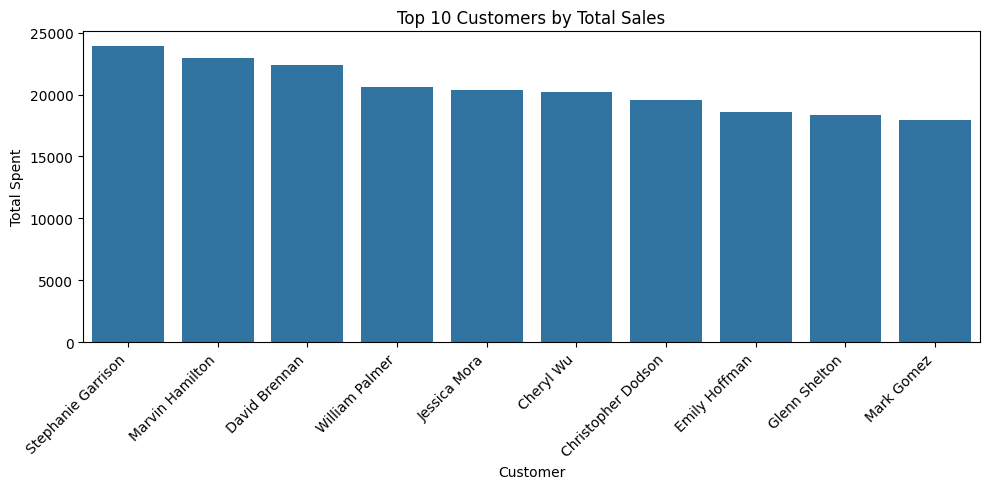

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Limit to top 10 customers for readability
top10 = df_top_customers_pd.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top10, x="name", y="total_spent")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Customers by Total Sales")
plt.xlabel("Customer")
plt.ylabel("Total Spent")
plt.tight_layout()
plt.show()

## Sales by region
Aggregate total sales by customer region to see geographic performance.

In [11]:
from pyspark.sql import functions as F

df_drill_region = spark.sql("""
    SELECT
        c.region,
        SUM(s.sales_amount) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = CAST(c.customer_id AS STRING)
    GROUP BY c.region
    ORDER BY total_sales DESC
""")

df_drill_region.show()

+----------+------------------+
|    region|       total_sales|
+----------+------------------+
|      east| 679700.7800000004|
|     north|         386291.78|
|      west|345515.14999999997|
|     south|209758.95999999996|
|south-west|207619.52000000002|
|   central|         197350.83|
|          |            288.11|
+----------+------------------+



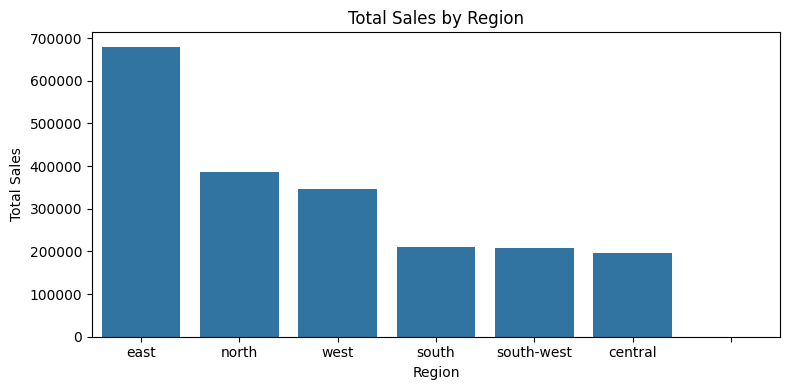

In [12]:
df_drill_region_pd = df_drill_region.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(data=df_drill_region_pd, x="region", y="total_sales")
plt.title("Total Sales by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

## Region × Product Category (dice)
Break down sales by both region and product category to spot category strengths per region.

In [13]:
df_drill_region_category = spark.sql("""
    SELECT
        c.region,
        p.category AS product_category,
        SUM(s.sales_amount) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = CAST(c.customer_id AS STRING)
    JOIN products p
        ON s.product_id = p.product_id
    GROUP BY
        c.region,
        p.category
    ORDER BY
        c.region,
        total_sales DESC
""")

df_drill_region_category.show(20)

+----------+----------------+------------------+
|    region|product_category|       total_sales|
+----------+----------------+------------------+
|          |     Electronics|            288.11|
|   central|          Office|55409.810000000005|
|   central|        Clothing|50431.969999999994|
|   central|     Electronics|          46391.76|
|   central|            Home| 45117.28999999999|
|      east|            Home|201646.94999999992|
|      east|     Electronics|192588.34000000005|
|      east|        Clothing|165987.00000000006|
|      east|          Office|119478.48999999998|
|     north|            Home|108436.17999999995|
|     north|     Electronics|101109.14000000003|
|     north|          Office| 90916.30999999995|
|     north|        Clothing| 85830.15000000002|
|     south|        Clothing| 65946.96999999999|
|     south|          Office| 51793.10000000001|
|     south|            Home| 51765.58999999999|
|     south|     Electronics|40253.299999999996|
|south-west|        

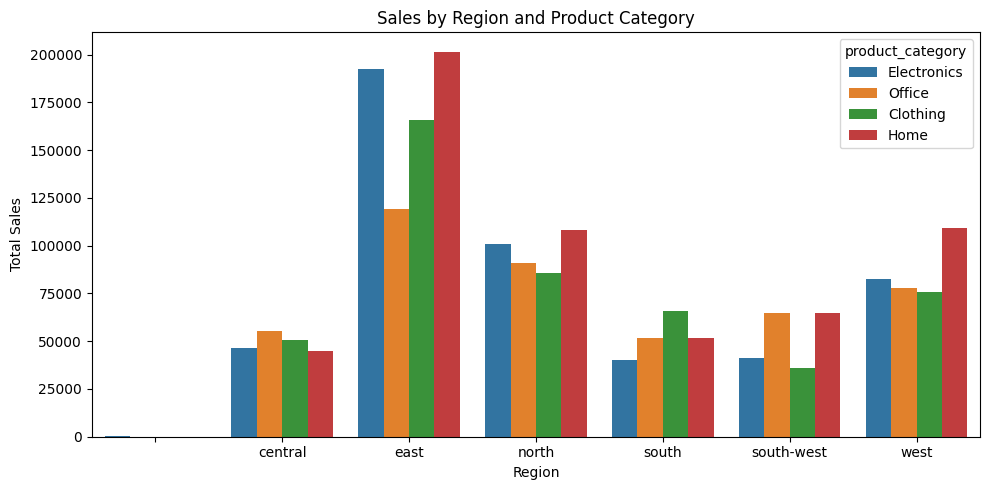

In [14]:
df_drill_region_category_pd = df_drill_region_category.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_drill_region_category_pd,
    x="region",
    y="total_sales",
    hue="product_category"
)
plt.title("Sales by Region and Product Category")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

In [15]:
df_region_trend = spark.sql("""
    SELECT
        c.region,
        SUM(s.sales_amount) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = CAST(c.customer_id AS STRING)
    GROUP BY c.region
    ORDER BY total_sales DESC
""")

df_region_trend.show()

+----------+------------------+
|    region|       total_sales|
+----------+------------------+
|      east| 679700.7800000004|
|     north|         386291.78|
|      west|345515.14999999997|
|     south|209758.95999999996|
|south-west|207619.52000000002|
|   central|         197350.83|
|          |            288.11|
+----------+------------------+



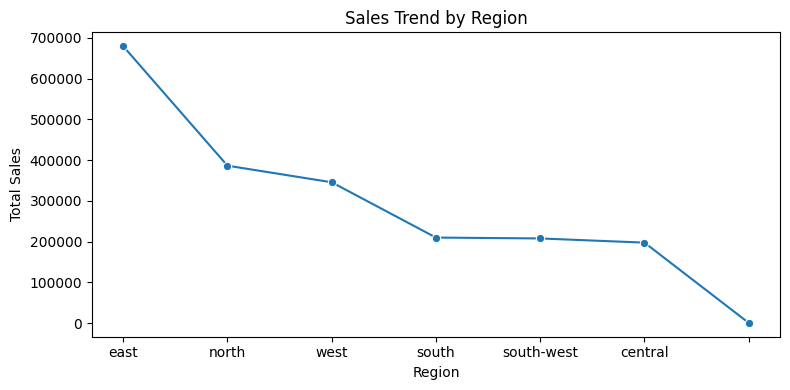

In [16]:
df_region_trend_pd = df_region_trend.toPandas()

plt.figure(figsize=(8, 4))
sns.lineplot(data=df_region_trend_pd, x="region", y="total_sales", marker="o")
plt.title("Sales Trend by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

In [17]:
df_region_category = spark.sql("""
    SELECT
        c.region,
        p.category AS product_category,
        SUM(s.sales_amount) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = CAST(c.customer_id AS STRING)
    JOIN products p
        ON s.product_id = p.product_id
    GROUP BY
        c.region,
        p.category
    ORDER BY
        c.region,
        total_sales DESC
""")

df_region_category.show(20)

+----------+----------------+------------------+
|    region|product_category|       total_sales|
+----------+----------------+------------------+
|          |     Electronics|            288.11|
|   central|          Office|55409.810000000005|
|   central|        Clothing|50431.969999999994|
|   central|     Electronics|          46391.76|
|   central|            Home| 45117.28999999999|
|      east|            Home|201646.94999999995|
|      east|     Electronics|192588.34000000005|
|      east|        Clothing|165987.00000000006|
|      east|          Office|119478.48999999998|
|     north|            Home|108436.17999999995|
|     north|     Electronics|101109.14000000004|
|     north|          Office| 90916.30999999995|
|     north|        Clothing| 85830.15000000004|
|     south|        Clothing|          65946.97|
|     south|          Office| 51793.10000000002|
|     south|            Home| 51765.58999999999|
|     south|     Electronics|40253.299999999996|
|south-west|        

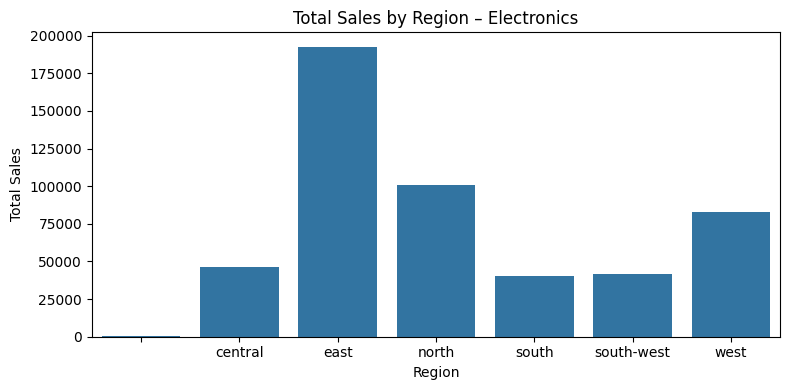

In [18]:
df_region_category_pd = df_region_category.toPandas()

# Choose one category to "slice" on
category_filter = "Electronics"   # change to any valid category
df_slice = df_region_category_pd[df_region_category_pd["product_category"] == category_filter]

plt.figure(figsize=(8, 4))
sns.barplot(data=df_slice, x="region", y="total_sales")
plt.title(f"Total Sales by Region – {category_filter}")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()